# Evaluating GSAT Score on Multiple Chinese LLM

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [8]:
results = pd.read_csv("./results.csv" , index_col=False)
results.head()

,model,short_name,result
0,ikala/bloom-zh-3b-chat,bloom-3b,112-ch-result-bloom3b.csv
1,taide/Llama3-TAIDE-LX-8B-Chat-Alpha1,taide-8b,112-ch-result-taide8b.csv
2,MediaTek-Research/Breeze-7B-32k-Instruct-v1_0,breeze-7b,112-ch-result-breeze7b.csv
3,Qwen/Qwen1.5-7B-Chat,qwen-7b,112-ch-result-qwen7b.csv
4,Qwen/Qwen1.5-MoE-A2.7B-Chat,qwen-2.7b,112-ch-result-qwen2.7b.csv


In [9]:
test_name = "112GSAT-Chinese"
questions = pd.read_csv("../dataset/chinese/112_chinese.csv")
questions.head()

,info,answer,explanation,question
0,112年學測-國文科第1題,A,NaN,下列「」內的字，讀音前後相同的是： (A)胡「笳」之拍／僧侶「袈」裟 (C)驀然而「踣」／「...
1,112年學測-國文科第2題,C,NaN,下列文句，完全沒有錯別字的是： (A)收藏家的稀世珍品樣樣價格不斐 (B)這起工安意外明顯是...
2,112年學測-國文科第3題,A,NaN,下列文句畫底線處的詞語，運用最適當的是： (A)這宗懸案經專案小組擘肌分理，已掌握部分有利線...
3,112年學測-國文科第4題,D,NaN,關於表一、表二，最適當的解讀是： 王昌齡 92.73 % (現存275 首詩) 62.64 ...
4,112年學測-國文科第5題,D,NaN,溝通交涉時，說話者會自居某個角色，或讓受話者處於某個角色，以利達成目的。下列關於甲、乙的解說...


In [12]:
result_dfs = [pd.read_csv(file) for file in results["result"]]
scores = [df["score"].sum() for df in result_dfs]
results["score"] = scores
results["score"] /= len(questions.index)
results["score"] *= 100
results.head()

,model,short_name,result,score
0,ikala/bloom-zh-3b-chat,bloom-3b,112-ch-result-bloom3b.csv,20.000000
1,taide/Llama3-TAIDE-LX-8B-Chat-Alpha1,taide-8b,112-ch-result-taide8b.csv,20.588235
2,MediaTek-Research/Breeze-7B-32k-Instruct-v1_0,breeze-7b,112-ch-result-breeze7b.csv,47.058824
3,Qwen/Qwen1.5-7B-Chat,qwen-7b,112-ch-result-qwen7b.csv,44.117647
4,Qwen/Qwen1.5-MoE-A2.7B-Chat,qwen-2.7b,112-ch-result-qwen2.7b.csv,44.117647


/tmp/ipykernel_1629102/2048539095.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Vega20c')


ValueError: 'Vega20c' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

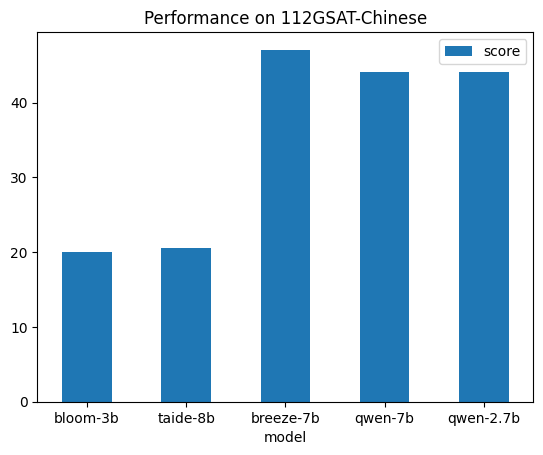

In [22]:
results.plot.bar(x='short_name', y='score', rot=0 , title=f"Performance on {test_name}" , xlabel="model")
cm = plt.cm.get_cmap('Blues')
plt.axhline(y=62.63,linewidth=1,ls="--" ,color=cm.colors[0], label="12th")
plt.axhline(y=57.41,linewidth=1,ls="--" ,color=cm.colors[1],label="25th")
plt.axhline(y=52.19,linewidth=1,ls="--" ,color=cm.colors[2], label="50th")
plt.axhline(y=41.75,linewidth=1,ls="--" ,color=cm.colors[3], label="67th")
plt.axhline(y=36.54,linewidth=1,ls="--" ,color=cm.colors[4], label="75th")
plt.legend()